In [216]:
# Importing libraries and setting up the environment
import warnings

warnings.filterwarnings("ignore")  # setting ignore as a parameter
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from mpl_toolkits.basemap import Basemap
from statsmodels.genmod.families import Binomial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.interpolate import Rbf
from scipy.interpolate import griddata

image_format = "svg"

In [217]:
# Predefined Code: Set up the data paths and color maps

# CSV files for all models share the same root path.
shared_root_path = (
    "/processing/"
)

#  CSV files for all models share the same path except for the model name
bakeoff_data_shared_path = "/data/output_bakeoff/2070-2100_bakeoff.csv"

# Historical Land Cover Color Map
current_vegetation_cmap = ListedColormap(
    ["#7570b3", "#9ACD32", "#1b9d77", "#0F52BA", "#A4D4B4", "#004953"]
)

# Set Future Land Cover Color Map
# Set Future Land Cover Color Map
future_vegetation_cmap = ListedColormap(
    [
        "#7570b3",
        "#9ACD32",
        "#1b9d77",
        "#0F52BA",
        "#EEBC1D",
        "#cb7e0c",
        "#A4D4B4",
        "#004953",
    ]
)

# Create a list of labels for the different colors in the colormap
current_vegetation_list = [
    "Boreal Forests",
    "Mixed Temperate Forests",
    "Temperate Coniferous Forests",
    "Temperate Deciduous Forests",
    "Xeromorphic Forests and Woodlands",
    "Temperate Broadleaved Evergreen Forests",
]
future_vegetation_list = [
    "Boreal Forests",
    "Mixed Temperate Forests",
    "Temperate Coniferous Forests",
    "Temperate Deciduous Forests",
    "Short Grasslands",
    "Arid Shrublands",
    "Xeromorphic Forests and Woodlands",
    "Temperate Broadleaved Evergreen Forests",
]

In [218]:
# Import Current Landcover Data
historical_model = pd.read_csv(
    shared_root_path + "united_states_1/data/output_bakeoff/PRE-2015_FC.csv",
    names=["LON", "LAT", "VEGETATION_TYPE"],
)


# Create a dictionary to map the PFT identifiers to the new ones
mapping_historical = {10: 20, 4: 5, 8: 10, 9: 15, 19: 25, 33: 30}
historical_model["VEGETATION_TYPE"] = historical_model["VEGETATION_TYPE"].map(
    mapping_historical
)

In [219]:
# Import  Future Models Data

# Create a list of the column names for the .csv files
cols = ["LON", "LAT", "TYPE"]

# Australia
model_1 = pd.read_csv(
    shared_root_path + "australia" + bakeoff_data_shared_path,
    names=cols,
)
# Canada
model_2 = pd.read_csv(
    shared_root_path + "canada" + bakeoff_data_shared_path, names=cols
)
# China
model_3 = pd.read_csv(shared_root_path + "china" + bakeoff_data_shared_path, names=cols)
# France
model_4 = pd.read_csv(
    shared_root_path + "france" + bakeoff_data_shared_path, names=cols
)
# Japan
model_5 = pd.read_csv(shared_root_path + "japan" + bakeoff_data_shared_path, names=cols)

# Norway
model_6 = pd.read_csv(
    shared_root_path + "norway" + bakeoff_data_shared_path, names=cols
)

# United Kingdom
model_7 = pd.read_csv(
    shared_root_path + "united_kingdom" + bakeoff_data_shared_path, names=cols
)

# United States CCSM4
model_8 = pd.read_csv(
    shared_root_path + "united_states_1" + bakeoff_data_shared_path, names=cols
)

# United States GFDL
model_9 = pd.read_csv(
    shared_root_path + "united_states_2" + bakeoff_data_shared_path, names=cols
)

In [220]:
# Aggregate the models and select the mode
agg_models = model_1.merge(model_2, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_3, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_4, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_5, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_6, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_7, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_8, on=["LON", "LAT"], how="left")
agg_models = agg_models.merge(model_9, on=["LON", "LAT"], how="left")

# Get the mode of the climate models
agg_models["VEGETATION_TYPE"] = agg_models.mode(axis=1)[0]
# Filter out the columns that are not needed
agg_models = agg_models[["LON", "LAT", "VEGETATION_TYPE"]]


# Create a dictionary to map the PFT identifiers to the new ones
mapping_future = {15: 30, 10: 20, 4: 5, 8: 10, 9: 15, 13: 25, 19: 35, 33: 40}
agg_models["VEGETATION_TYPE"] = agg_models["VEGETATION_TYPE"].map(mapping_future)

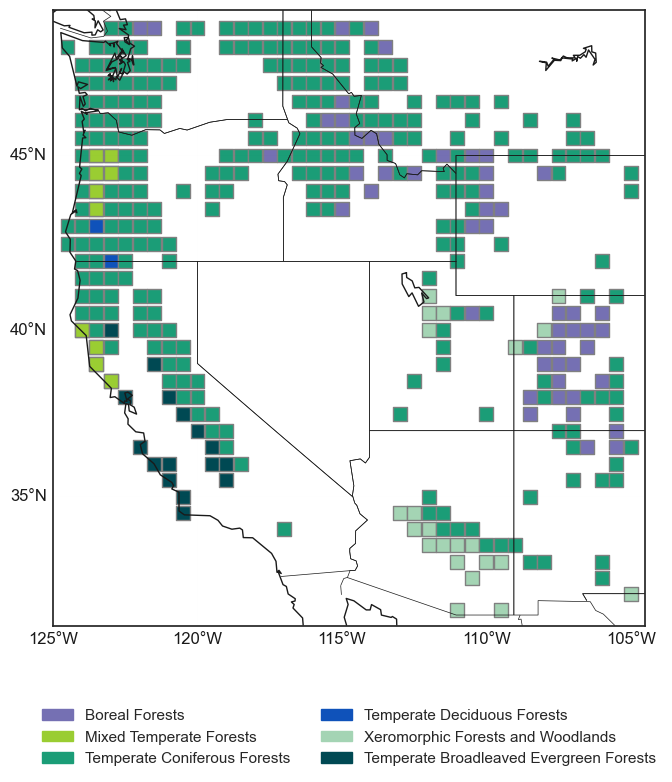

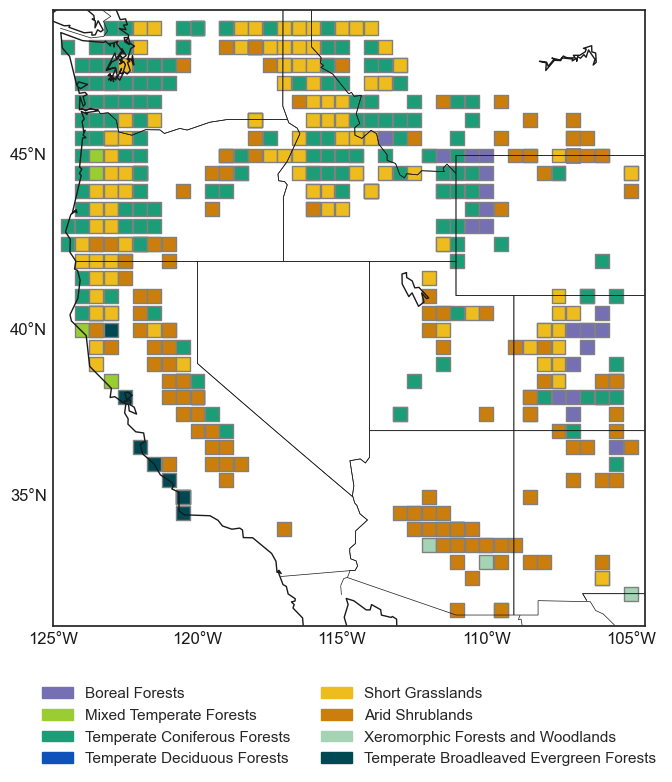

In [221]:
# Function to plot the results
def plot_figure(df, colormap, vegetation_list, file_name):
    fig = plt.figure()
    fig.set_size_inches(25, 8)
    ax = fig.add_subplot(111)
    sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})
    plt.rcParams["font.size"] = 12
    m = Basemap(
        projection="mill",
        llcrnrlat=31,
        llcrnrlon=-125,
        urcrnrlat=49,
        urcrnrlon=-104.5,
        resolution="l",
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    # Draw parallels and meridians
    lat_interval = 5
    lon_interval = 5
    parallels = np.arange(25, 50, lat_interval)
    meridians = np.arange(-130, -104.5, lon_interval)
    m.drawparallels(
        parallels, labels=[True, False, False, False], fontsize=12, linewidth=0.001
    )
    m.drawmeridians(
        meridians, labels=[False, False, False, True], fontsize=12, linewidth=0.001
    )

    x, y = m(df["LON"].values, df["LAT"].values)
    m.scatter(
        x,
        y,
        c=df["VEGETATION_TYPE"],
        s=100,
        cmap=colormap,
        edgecolor="gray",
        marker="s",
    )
    #  a list of labels for the different colors in the colormap
    labels = vegetation_list

    # Create a list of patches for the legend
    patches = [
        Patch(color=color, label=label) for color, label in zip(colormap.colors, labels)
    ]
    # Add the legend to the axis
    ax.legend(
        handles=patches,
        bbox_to_anchor=(0.5, -0.25),
        loc="lower center",
        ncol=2,
        borderaxespad=0.5,
        frameon=False,
    )

    plt.savefig(
        "../figures/" + file_name,
        format=image_format,
        dpi=1200,
        bbox_inches="tight",
    )


# Plot Current Land Cover
plot_figure(
    historical_model,
    current_vegetation_cmap,
    current_vegetation_list,
    "current_landcover." + image_format,
)
# Plot End of Century Land Cover
plot_figure(
    agg_models,
    future_vegetation_cmap,
    future_vegetation_list,
    "end_century_landcover." + image_format,
)

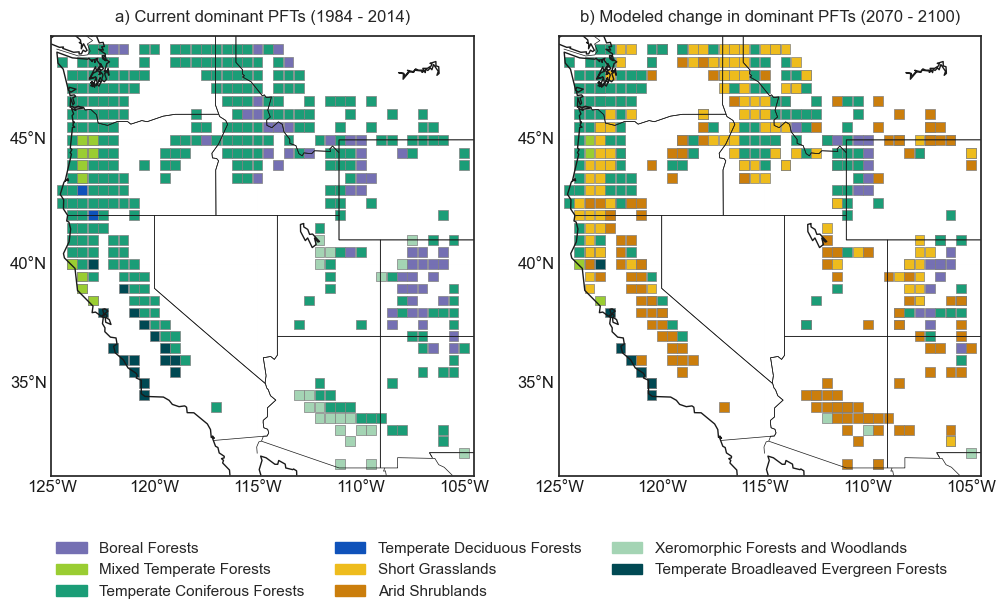

In [ ]:

# Create a list of data to plot in each subplot
data_list = [historical_model, agg_models]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, data in enumerate(data_list):
    # add missing grids with -99999 value
    lons = np.arange(-125, -104.5, 0.5)
    lats = np.arange(31, 49, 0.5)
    for lon in lons:
        for lat in lats:
            if not ((data["LON"] == lon) & (data["LAT"] == lat)).any():

                data = pd.concat([data, pd.DataFrame({"LON": lon, "LAT": lat, "VEGETATION_TYPE": [-99999]})], ignore_index=True)

    # sort the data by longitude and latitude
    data = data.sort_values(by=["LON", "LAT"])

    # interpolate data to 0.25 by 0.25
    lon_new, lat_new = np.meshgrid(np.arange(-125, -104.5, 0.5), np.arange(31, 49, 0.5))
    z = griddata((data["LON"], data["LAT"]), data["VEGETATION_TYPE"], (lon_new, lat_new), method="linear")

    # plot the data using pcolormesh
    ax[i].set_title("a) Current dominant PFTs (1984 - 2014)" if i == 0 else "b) Modeled change in dominant PFTs (2070 - 2100)", pad=10)
    
    # Get the appropriate colormap for the subplot
    if i == 0:
        cmap = current_vegetation_cmap
    else:
        cmap = future_vegetation_cmap
        
        
    sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})
    m = Basemap(
        projection="mill",
        llcrnrlat=31,
        llcrnrlon=-125,
        urcrnrlat=49,
        urcrnrlon=-104.5,
        resolution="l",
        ax=ax[i]
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    x, y = m(lon_new, lat_new)

    # set the color of grids with VEGETATION_TYPE == -99999 to white
    z_masked = np.ma.masked_where(z == -99999, z)
    
    
    

    m.pcolormesh(x, y, z_masked, cmap=cmap,edgecolor="white", linewidth=0.5)

    # set the intervals for parallels and meridians
    lat_interval = 5
    lon_interval = 5

    # draw parallels and meridians
    parallels = np.arange(25, 50, lat_interval)
    meridians = np.arange(-130, -104.5, lon_interval)
    m.drawparallels(
        parallels, labels=[True, False, False, False], fontsize=12, linewidth=0.001
    )
    m.drawmeridians(
        meridians, labels=[False, False, False, True], fontsize=12, linewidth=0.001
    )

    # Create a list of patches for the legend
    patches = [
        Patch(color=color, label=label) for color, label in zip(future_vegetation_cmap.colors, future_vegetation_list)
    ]

 

 # Create a list of patches for the legend
    patches = [
        Patch(color=color, label=label) for color, label in zip(future_vegetation_cmap.colors, future_vegetation_list)
    ]

# Add the legend to the figure
fig.legend(
    handles=patches,
    bbox_to_anchor=(0.5, -0.1),
    loc="lower center",
    ncol=3,
    borderaxespad=0.5,
    frameon=False,
)


# plt.savefig("../figures/landcover_compare." + image_format, format=image_format, dpi=1200, bbox_inches="tight")
plt.show()